## SudokuReader

In [1]:
using Images
using Plots
using FileIO
using Flux
using BSON

In [2]:
using Revise
Revise.includet("GridDetection/GridDetection.jl")
using .GridDetection

Revise.includet("DigitDetection/DigitExtraction.jl")
using .DigitExtration

Revise.includet("utilities/Transforms.jl")
using .Transforms

Revise.includet("utilities/align_centres.jl");

┌ Warning: Replacing docs for `Main.DigitExtration.calc_connected_component_statistics :: Tuple{AbstractArray, Int64}` in module `Main.DigitExtration`
└ @ Base.Docs docs\Docs.jl:240


## Load image

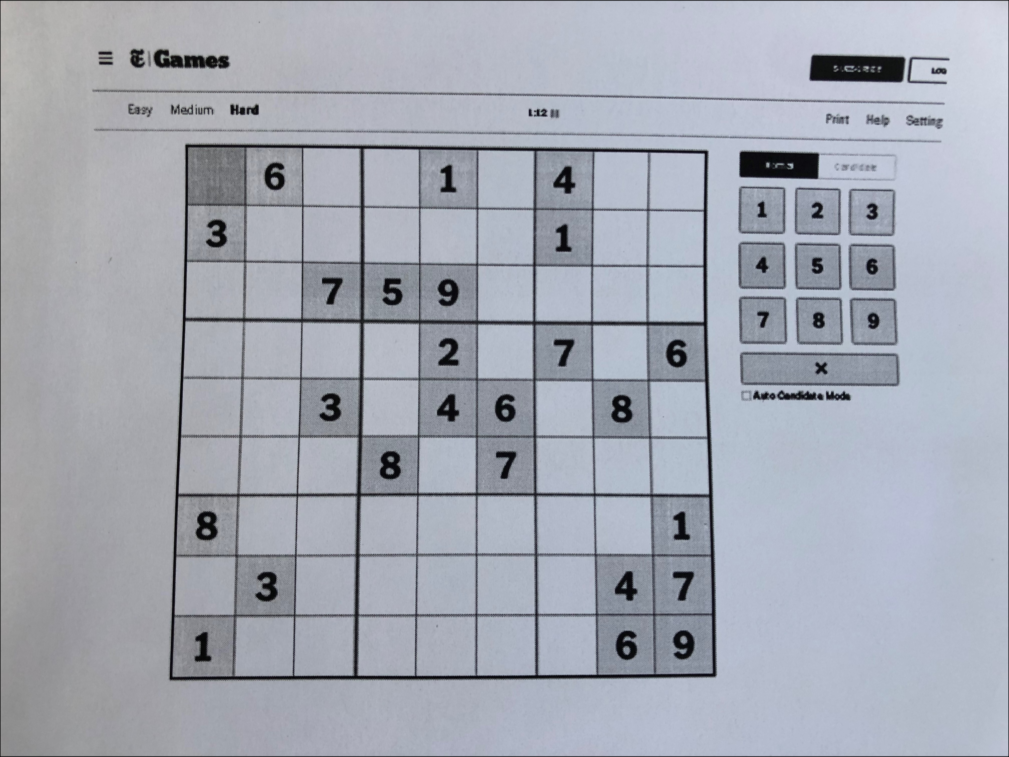

In [3]:
image_path = "images/nytimes_20210807.jpg";
image_raw = load(image_path)
image = copy(image_raw)

## Get grid

In [4]:
blackwhite, quad = detect_grid(
    image; 
    max_size=1024, 
    blur_window_size=5, σ=1.1, 
    threshold_window_size=15, threshold_percentage=7);

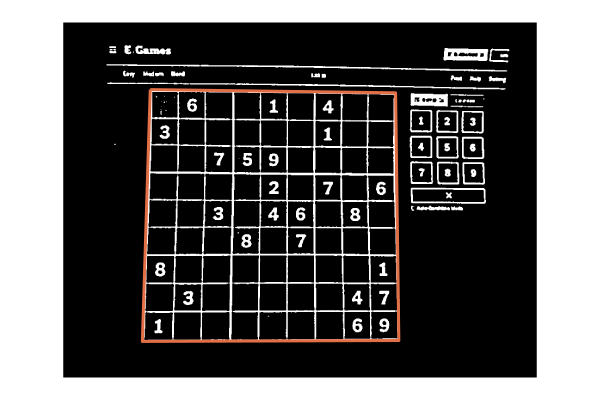

In [5]:
canvas = plot(blackwhite)

x = [point[2] for point in vcat(quad, quad[1])]
y = [point[1] for point in vcat(quad, quad[1])]
plot!(canvas, x, y, linewidth=3, label="", ticks=:none, border=:none)

## Extract digits

  1.259047 seconds (4.53 M allocations: 282.622 MiB, 5.78% gc time, 84.17% compilation time)


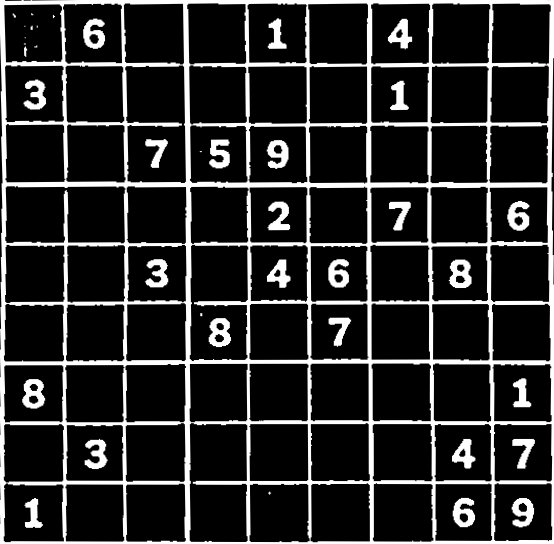

In [6]:
@time warped, invM = four_point_transform(blackwhite, quad)
warped

In [23]:
BSON.@load "DigitDetection\\models\\LeNet5_e20.bson" model
model(zeros(Float32, (28, 28, 1, 1))) # compile
model

Chain(
  Conv((5, 5), 1 => 6, relu),           # 156 parameters
  MaxPool((2, 2)),
  Conv((5, 5), 6 => 16, relu),          # 2_416 parameters
  MaxPool((2, 2)),
  Flux.flatten,
  Dense(256, 120, relu),                # 30_840 parameters
  Dense(120, 84, relu),                 # 10_164 parameters
  Dense(84, 10),                        # 850 parameters
)                   # Total: 10 arrays, 44_426 parameters, 174.867 KiB.

In [24]:
grid, centres, probs = read_digits(warped, model, offset_ratio=0.1, radius_ratio=0.25, detection_threshold=0.1);

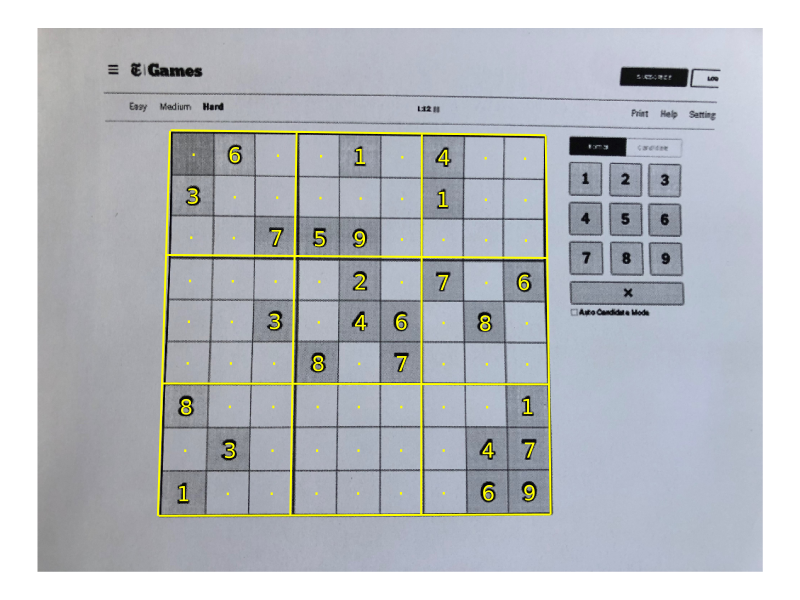

In [25]:
pred_threshold = 0.90
image_out = imresize(image, size(blackwhite));
canvas = plot(image_out, ticks=nothing, border=:none, size=(800, 600));

for line in construct_grid(size(warped, 1), size(warped, 2), nblocks=3)
    line_unwarped = map(point -> perspective_transform(invM)(point), line)
    xs = [point[2] for point in line_unwarped]
    ys = [point[1] for point in line_unwarped]
    plot!(canvas, xs, ys, label="", linewidth=2, color=:yellow)
end

centres_aligned = align_centres(centres, probs .> pred_threshold)
for i in 1:9
    for j in 1:9
        centre = centres_aligned[i, j]
        centre_unwarped = perspective_transform(invM)(centre)
        label =  (probs[i, j] > pred_threshold) ? string(grid[i, j]) : "·"
        annotate!(canvas, centre_unwarped[2], centre_unwarped[1], label, :yellow)
    end
end
canvas

In [26]:
filepath, ext = splitext(image_path)
filename = splitpath(filepath)[end]
savefig(canvas, joinpath("images\\outputs", filename * "_read" * ".png"))

## solve puzzle

⚠️ SudokuSolver.jl is not part of this repository. 

In [27]:
include("../SudokuSolver-jl/Sudokus.jl")
using .Sudokus
include("../SudokuSolver-jl/sudoku_solver.jl")

flush_candidates! (generic function with 2 methods)

In [28]:
grid_orig = copy(grid)
pred_threshold = 0.90
grid_orig[probs .< pred_threshold] .= 0
solution_set, info = solve_sudoku(grid_orig, all_solutions=false)
if isempty(solution_set)
    println("no solution found!")
    grid_solved = grid
else
    grid_solved = solution_set[1]
end

9×9 Matrix{Int64}:
 2  6  8  7  1  3  4  9  5
 3  5  9  2  6  4  1  7  8
 4  1  7  5  9  8  6  2  3
 5  8  4  3  2  9  7  1  6
 7  9  3  1  4  6  5  8  2
 6  2  1  8  5  7  9  3  4
 8  4  6  9  7  2  3  5  1
 9  3  5  6  8  1  2  4  7
 1  7  2  4  3  5  8  6  9

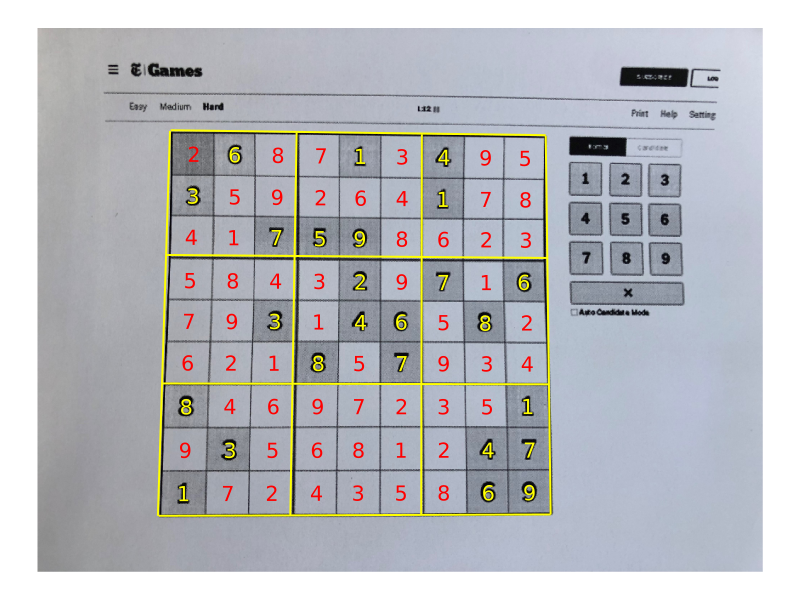

In [29]:
image_out = imresize(image, size(blackwhite));
canvas = plot(image_out, ticks=nothing, border=:none, size=(800, 600));

for line in construct_grid(size(warped, 1), size(warped, 2))
    line_unwarped = map(point -> perspective_transform(invM)(point), line)
    xs = [point[2] for point in line_unwarped]
    ys = [point[1] for point in line_unwarped]
    plot!(xs, ys, label="", linewidth=2, color=:yellow)
end

centres_aligned = align_centres(centres, grid_orig .> 0)
for i in 1:9
    for j in 1:9
        centre = centres_aligned[i, j]
        centre_unwarped = perspective_transform(invM)(centre)
        color = (grid_orig[i, j] > 0) ? :yellow : :red
        annotate!(canvas, centre_unwarped[2], centre_unwarped[1], string(grid_solved[i, j]), color)
    end
end
canvas

In [30]:
filepath, ext = splitext(image_path)
filename = splitpath(filepath)[end]
savefig(canvas, joinpath("images\\outputs", filename * "_solved" * ".png"))